In [3]:
# define logging and working directory
from ProjectRoot import change_wd_to_project_root 
change_wd_to_project_root()
#from pyforest import *
from src.utils.Notebook_imports import *
from src.utils.Metrics_acdc import compute_metrics_on_files, compute_metrics_on_directories
from src.visualization.Visualize import bland_altman_metric_plot, create_eval_plot
Console_and_file_logger('Evaluation', logging.INFO)
import matplotlib.pyplot as plt
# jupyter magic config
%matplotlib inline
%reload_ext autoreload
%autoreload 2

2020-11-27 20:06:52,113 INFO -------------------- Start --------------------
2020-11-27 20:06:52,113 INFO Working directory: /mnt/ssd/git/3d-mri-domain-adaption.
2020-11-27 20:06:52,114 INFO Log file: ./logs/Evaluation.log
2020-11-27 20:06:52,114 INFO Log level for console: INFO


search for root_dir and set working directory
Working directory set to: /mnt/ssd/git/3d-mri-domain-adaption


In [10]:
# select folder with the images and masks
# choose the root folder before the gt/pred sub-folders
from ipyfilechooser import FileChooser
path_chooser = FileChooser(os.path.join(os.getcwd(),'data/predicted/'), '')
display(path_chooser)

FileChooser(path='/mnt/ssd/git/3d-mri-domain-adaption/data/predicted', filename='', title='HTML(value='', layo…

In [15]:
root_path = path_chooser.selected

gt_path = os.path.join(root_path, 'gt')
#gt_path = 'data/temp/gt'
gt = sorted(glob.glob(os.path.join(gt_path, '*')))
logging.info('GT files: {}'.format(len(gt)))
logging.info(gt[:5])

pred_path = os.path.join(root_path, 'pred')
#pred_path = 'data/temp/pred'
pred = sorted(glob.glob(os.path.join(pred_path, '*')))
logging.info('Pred files: {}'.format(len(pred)))
logging.info(pred[:5])

# proof if we have one gt file for each prediction and vize versa
p = set(os.path.basename(elem) for elem in pred)
g = set(os.path.basename(elem) for elem in gt)
logging.info(g-p)
logging.info(p-g)
logging.info(len(p.intersection(g)))
compute_metrics_on_directories(gt_path, pred_path, results_path=os.path.join(root_path,'results.csv'))

2020-12-01 16:29:58,163 INFO GT files: 42
2020-12-01 16:29:58,164 INFO ['/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/tests_72_112_112_sp3_1ax_1sax_1focus_thres08_inpl_f0_2nd_unet_round_crop/3D/gt/0000-0HQQW4ZN_2007-05-23_ED_msk.nrrd', '/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/tests_72_112_112_sp3_1ax_1sax_1focus_thres08_inpl_f0_2nd_unet_round_crop/3D/gt/0000-0HQQW4ZN_2007-05-23_ES_msk.nrrd', '/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/tests_72_112_112_sp3_1ax_1sax_1focus_thres08_inpl_f0_2nd_unet_round_crop/3D/gt/0000-13JLP3HN_2007-05-22_ED_msk.nrrd', '/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/tests_72_112_112_sp3_1ax_1sax_1focus_thres08_inpl_f0_2nd_unet_round_crop/3D/gt/0000-13JLP3HN_2007-05-22_ES_msk.nrrd', '/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/tests_72_112_112_sp3_1ax_1sax_1focus_thres08_inpl_f0_2nd_unet_round_crop/3D/gt/0000-24YLF77L_2007-11-19_ED_msk.nrrd']
2020-12-01 16:29:58,165 INFO Pred files: 42
2020-12-01 16:29:58,165 INFO ['/mn

The first supplied array does not contain any binary object.
The first supplied array does not contain any binary object.
The first supplied array does not contain any binary object.


In [17]:
@interact_manual
def load_evaluation(eval_path = sorted(glob.glob('data/predicted/**/**/*.csv')), save=False, file_name='temp_violin'):
    print(eval_path)
    import pandas as pd
    global eval, df_dice, df_hd, df_vol
    eval = pd.read_csv(eval_path)
    print(eval.columns)
    # df need to be melt down = every row represented by one value
    # first define melting/categorical columns, second define all values
    empty_predictions = eval.shape[0] - eval.dropna().shape[0]
    print('empty predictions: {}'.format(empty_predictions))
    try:
        df_hd = pd.melt(eval, ['Name'], ['Hausdorff LV', 'Hausdorff RV', 'Hausdorff MYO'])
    except Exception as e:
        print('no hausdorff given')
    df_dice = pd.melt(eval, ['Name'], ['Dice LV', 'Dice RV', 'Dice MYO'])
    df_diff = pd.melt(eval, ['Name'], ['Err LV(ml)', 'Err RV(ml)', 'Err MYO(ml)'])
    df_vol = pd.melt(eval, ['Name'], ['Volume LV', 'Volume RV', 'Volume MYO'])
    fig = create_eval_plot(df_dice, df_hd, df_diff, df_vol, eval)
    if save:
        plt.savefig('reports/figures/{}.png'.format(file_name),bbox_inches='tight')
    return(eval.head())

interactive(children=(Dropdown(description='eval_path', options=('data/predicted/excl_AX_on_AX_test/3D/results…

In [13]:
eval[eval['Dice RV']< 0.6].head()

,Name,Dice LV,Volume LV,Err LV(ml),Hausdorff LV,Dice RV,Volume RV,Err RV(ml),Hausdorff RV,Dice MYO,Volume MYO,Err MYO(ml),Hausdorff MYO
3,0000-2CVUG1C5_2006-09-06_ES_msk,0.784799,50.98392,6.17526,4.123106,0.491021,83.93892,-164.14632,16.186414,0.687759,103.60038,-12.65472,7.874008
12,0000-5W8RFCJD_2005-04-18_ED_msk,0.733160,138.13722,-93.27786,7.681146,0.570396,167.68518,-220.05828,18.193405,0.411275,61.93512,-31.90044,12.845233
13,0000-5W8RFCJD_2005-04-18_ES_msk,0.652399,41.11770,-31.47456,10.440307,0.283057,44.06844,-216.00228,31.400637,0.423517,44.41320,-28.96998,8.602325
31,0000-GYMP57R6_2006-12-18_ES_msk,0.818592,140.67222,-10.76868,6.557439,0.584229,233.20986,-129.97452,28.178006,0.708961,158.44764,-38.41032,7.549834
34,0000-JDRPF7F4_2006-02-28_ED_msk,0.823768,208.87386,-11.94492,9.219544,0.437505,192.80196,-427.53282,27.928480,0.659375,212.56482,-81.95148,12.000000


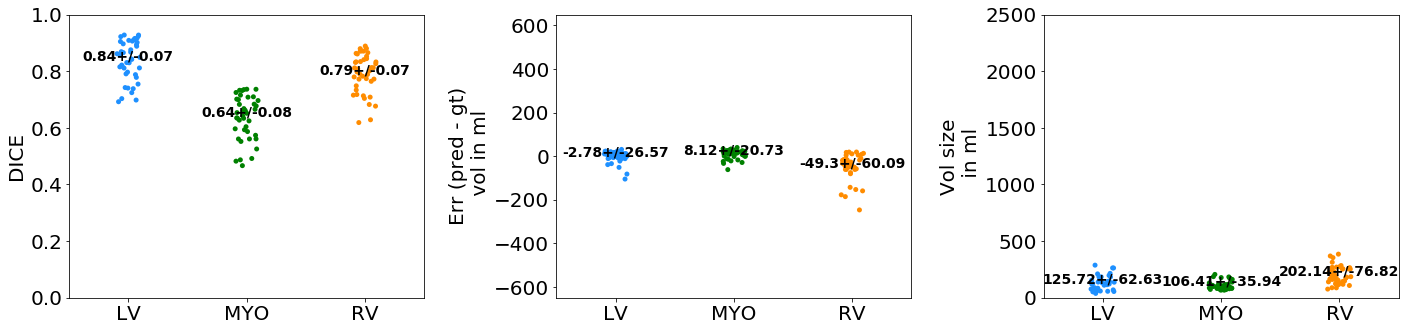

In [30]:
# create a scatterplot
# nobs = mean
import seaborn as sns
#plt.rcParams['font.fontname'] = "Cambria"
outliers = False

plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5), sharey=False)
my_pal_1 = {"Dice LV": "dodgerblue", "Dice MYO": "g", "Dice RV":"darkorange"}
my_pal_2 = {"Err LV(ml)": "dodgerblue", "Err MYO(ml)": "g", "Err RV(ml)":"darkorange"}
my_pal_3 = {"Volume LV": "dodgerblue", "Volume MYO": "g", "Volume RV":"darkorange"}

ax1 = sns.stripplot(x= 'variable',y = 'value', data=df_dice,order=["Dice LV", "Dice MYO", "Dice RV"],palette=my_pal_1 , ax=ax1)
medians = df_dice.groupby(['variable'])['value'].mean().round(2)
sd = df_dice.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax1.get_xticklabels())),ax1.get_xticklabels()):
    _ = ax1.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax1, ylim=(0,1))
plt.setp(ax1, ylabel=('DICE'))
plt.setp(ax1, xlabel='')
ax1.set_xticklabels(['LV','MYO', 'RV'])

ax2 = sns.stripplot(x= 'variable',y = 'value', data=df_hd,order=["Err LV(ml)", "Err MYO(ml)", "Err RV(ml)"],palette=my_pal_2 , ax=ax2)
medians = df_hd.groupby(['variable'])['value'].mean().round(2)
sd = df_hd.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax2.get_xticklabels())),ax2.get_xticklabels()):
    _ = ax2.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax2, ylim=(-650,650))
plt.setp(ax2, ylabel=('Err (pred - gt)\n vol in ml'))
plt.setp(ax2, xlabel='')
ax2.set_xticklabels(['LV','MYO', 'RV'])
    
ax3 = sns.stripplot(x= 'variable',y = 'value',order=["Volume LV", "Volume MYO", "Volume RV"],palette=my_pal_3 , data=df_vol, ax=ax3)
medians = df_vol.groupby(['variable'])['value'].mean().round(2)
sd = df_vol.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax3.get_xticklabels())),ax3.get_xticklabels()):
    _ = ax3.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax3, ylim=(0,2500))
plt.setp(ax3, ylabel=('Vol size\n in ml'))
plt.setp(ax3, xlabel='')
ax3.set_xticklabels(['LV','MYO', 'RV'])
plt.tight_layout()

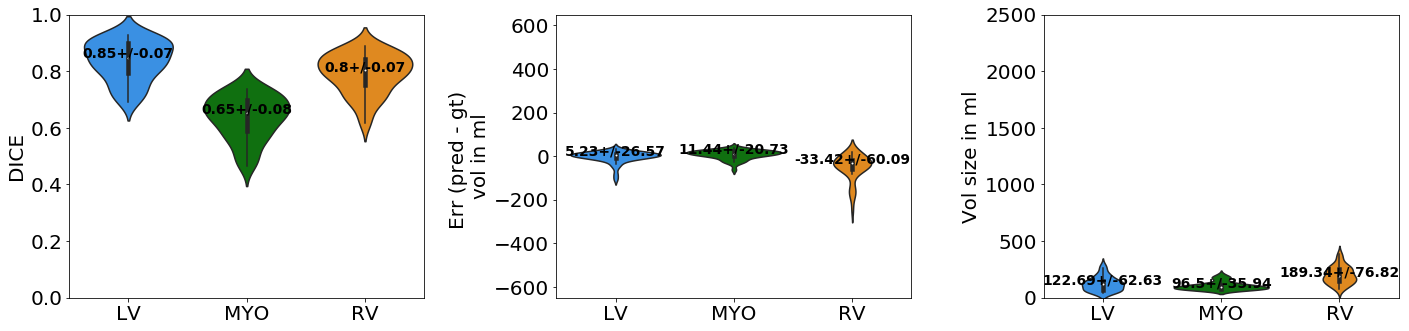

In [11]:
# create a violinplot
# nobs = median
import seaborn as sns
outliers = False


plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,5), sharey=False)

ax1 = sns.violinplot(x= 'variable',y = 'value', data=df_dice,order=["Dice LV", "Dice MYO", "Dice RV"], palette=my_pal_1 , showfliers = outliers, ax=ax1)
medians = df_dice.groupby(['variable'])['value'].median().round(2)
sd = df_dice.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax1.get_xticklabels())),ax1.get_xticklabels()):
    _ = ax1.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax1, ylim=(0,1))
plt.setp(ax1, ylabel=('DICE'))
plt.setp(ax1, xlabel='')
ax1.set_xticklabels(['LV','MYO', 'RV'])

ax2 = sns.violinplot(x= 'variable',y = 'value', data=df_hd,order=["Err LV(ml)", "Err MYO(ml)", "Err RV(ml)"],palette=my_pal_2 , showfliers = outliers, ax=ax2)
medians = df_hd.groupby(['variable'])['value'].median().round(2)
sd = df_hd.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax2.get_xticklabels())),ax2.get_xticklabels()):
    _ = ax2.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax2, ylim=(-650,650))
plt.setp(ax2, ylabel=('Err (pred - gt) \nvol in ml'))
plt.setp(ax2, xlabel='')
ax2.set_xticklabels(['LV','MYO', 'RV'])
    
ax3 = sns.violinplot(x= 'variable',y = 'value',order=["Volume LV", "Volume MYO", "Volume RV"],palette=my_pal_3 , showfliers = outliers, data=df_vol, ax=ax3)

medians = df_vol.groupby(['variable'])['value'].median().round(2)
sd = df_vol.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]


for tick,label in zip(range(len(ax3.get_xticklabels())),ax3.get_xticklabels()):
    _ = ax3.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax3, ylim=(0,2500))
plt.setp(ax3, ylabel=('Vol size in ml'))
plt.setp(ax3, xlabel='')
ax3.set_xticklabels(['LV','MYO', 'RV'])
plt.tight_layout()

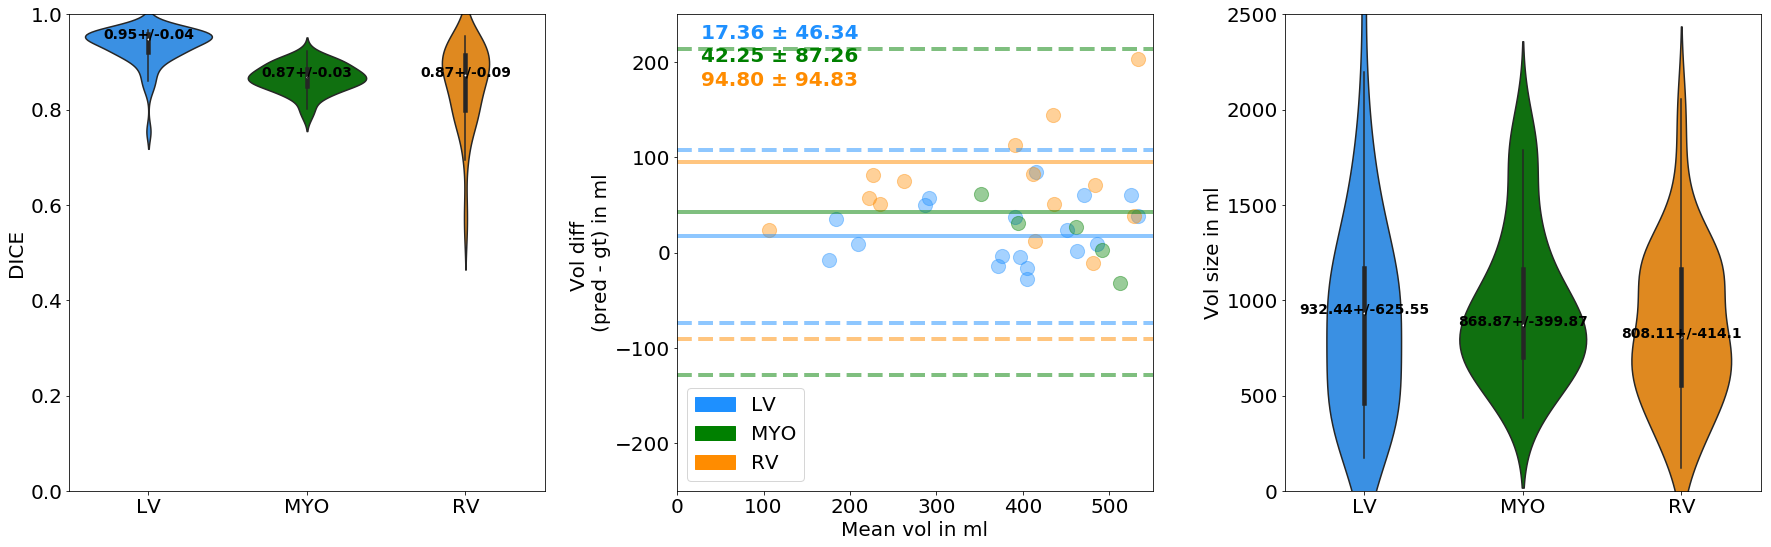

In [26]:
# create a violinplot with an integrated bland altmann plot
# nobs = median
import seaborn as sns
outliers = False
my_pal_1 = {"Dice LV": "dodgerblue", "Dice MYO": "g", "Dice RV":"darkorange"}
my_pal_2 = {"Err LV(ml)": "dodgerblue", "Err MYO(ml)": "g", "Err RV(ml)":"darkorange"}
my_pal_3 = {"Volume LV": "dodgerblue", "Volume MYO": "g", "Volume RV":"darkorange"}


plt.rcParams.update({'font.size': 20})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25,8), sharey=False)

ax1 = sns.violinplot(x= 'variable',y = 'value', data=df_dice,order=["Dice LV", "Dice MYO", "Dice RV"],palette=my_pal_1 , showfliers = outliers, ax=ax1)
medians = df_dice.groupby(['variable'])['value'].median().round(2)
sd = df_dice.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]

for tick,label in zip(range(len(ax1.get_xticklabels())),ax1.get_xticklabels()):
    _ = ax1.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax1, ylim=(0,1))
plt.setp(ax1, ylabel=('DICE'))
plt.setp(ax1, xlabel='')
ax1.set_xticklabels(['LV','MYO', 'RV'])

ax2 = bland_altman_metric_plot(eval, ax2)

ax3 = sns.violinplot(x= 'variable',y = 'value',order=["Volume LV", "Volume MYO", "Volume RV"], palette=my_pal_3, showfliers = outliers, data=df_vol, ax=ax3)

medians = df_vol.groupby(['variable'])['value'].median().round(2)
sd = df_vol.groupby(['variable'])['value'].std().round(2)
nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]


for tick,label in zip(range(len(ax3.get_xticklabels())),ax3.get_xticklabels()):
    _ = ax3.text(tick, medians[tick], nobs[tick],horizontalalignment='center', size='x-small', color='black', weight='semibold')
plt.setp(ax3, ylim=(0,2500))
plt.setp(ax3, ylabel=('Vol size in ml'))
plt.setp(ax3, xlabel='')
ax3.set_xticklabels(['LV','MYO', 'RV'])
plt.tight_layout()

In [53]:
def calc_mean_scores(df):
    
    df_dice = pd.melt(df, ['Name'], ['Dice LV', 'Dice RV', 'Dice MYO'])
    df_hd = pd.melt(df, ['Name'], ['Err LV(ml)', 'Err RV(ml)', 'Err MYO(ml)'])
    df_vol = pd.melt(df, ['Name'], ['Volume LV', 'Volume RV', 'Volume MYO'])
    
    d_mean = df['Dice LV', 'Dice RV', 'Dice MYO'].mean()
    d_median = df['Dice LV', 'Dice RV', 'Dice MYO'].median()
    d_sd = df['Dice LV', 'Dice RV', 'Dice MYO'].sd()
    df = pd.DataFrame()
    
    df.extend(medians_dice = df_dice.groupby(['variable'])['value'].median().round(2))
    mean_dice = df_dice.groupby(['variable'])['value'].mean().round(2)
    sd_dice = df_dice.groupby(['variable'])['value'].std().round(2)
    
    medians_hd = df_dice.groupby(['variable'])['value'].median().round(2)
    sd_hd = df_dice.groupby(['variable'])['value'].std().round(2)
    
    medians_vol = df_dice.groupby(['variable'])['value'].median().round(2)
    sd_vol = df_dice.groupby(['variable'])['value'].std().round(2)
    
    return d_mean, d_median, d_sd
    

In [81]:
cols = ['dice LV median','dice RV median','dice MYO median', 'dice LV mean', 'dice RV mean','dice MYO mean', 'dice LV sd', 'dice RV sd', 'dice MYO sd']
scores = []

scores.extend(df_dice.groupby(['variable'])['value'].median().round(2).values)
scores.extend(df_dice.groupby(['variable'])['value'].mean().round(2).values)
scores.extend(df_dice.groupby(['variable'])['value'].std().round(2).values)

df = pd.DataFrame(columns=cols)
df.append(scores)
df

,dice LV median,dice RV median,dice MYO median,dice LV mean,dice RV mean,dice MYO mean,dice LV sd,dice RV sd,dice MYO sd


In [31]:
eval.head()

,Name,Dice LV,Volume LV,Err LV(ml),Hausdorff LV,Dice RV,Volume RV,Err RV(ml),Hausdorff RV,Dice MYO,Volume MYO,Err MYO(ml),Hausdorff MYO
0,0000-0HQQW4ZN_2007-05-23_ED_msk,0.790685,88.313625,-30.324375,17.146428,0.841041,141.89175,-35.650125,11.357817,0.518385,53.770500,-2.878875,22.315914
1,0000-0HQQW4ZN_2007-05-23_ES_msk,0.830249,41.478750,2.176875,7.071068,0.805932,79.90650,-6.773625,13.341664,0.663478,51.067125,2.656125,12.083046
2,0000-2CVUG1C5_2006-09-06_ED_msk,0.827723,105.691500,11.677500,13.747727,0.830228,193.67100,-49.075875,18.466185,0.590159,91.459125,5.406750,18.466185
3,0000-2CVUG1C5_2006-09-06_ES_msk,0.732182,30.300750,-1.765125,19.949937,0.671528,83.32200,-74.013750,13.453624,0.497653,54.789750,-19.831500,23.895606
4,0000-2CW0G1A5_2006-04-06_ED_msk,0.856794,140.487750,-39.399750,12.328828,0.891899,226.42875,-44.178750,9.055385,0.629127,82.947375,-5.224500,20.832667


In [19]:
def get_dice(exp):
    df = pd.read_csv(exp)
    d_lv = df['Dice LV']
    d_rv = df['Dice RV']
    d_myo = df['Dice MYO']
    
    
    hd_lv = df['Hausdorff LV']
    hd_rv = df['Hausdorff RV']
    hd_myo = df['Hausdorff MYO']
    
    res = {'experiment':exp, 
           'dice lv mean':d_lv.mean(), 'dice lv sd':d_lv.std(),'HD lv mean':hd_lv.mean(), 'HD lv sd':hd_lv.std(),
           'dice lv median':d_lv.median(),'HD lv median':hd_lv.median(),
           
           'dice myo mean':d_myo.mean(), 'dice myo sd':d_myo.std(),'HD myo mean':hd_myo.mean(), 'HD myo sd':hd_myo.std(),
           'dice myo median':d_myo.median(),'HD myo median':hd_myo.median(),
           
           'dice rv mean':d_rv.mean(), 'dice rv sd':d_rv.std(),'HD rv mean':hd_rv.mean(), 'HD rv sd':hd_rv.std(),
           'dice rv median':d_rv.median(),'HD rv median':hd_rv.median()
          }
    return [res]

# Load one experiment evaluation, calc mean, std and median and merge into one dataframe

In [20]:
import pandas as pd
pd.set_option('display.max_colwidth', None)
df_scores = pd.DataFrame(columns=['experiment'])
@interact_manual
def load_evaluation(eval_path = sorted(glob.glob('data/predicted/**/**/*.csv'))):
    global df_scores
    print(eval_path)
    import pandas as pd
    
    res = get_dice(eval_path)
    # make sure every experiment is only once in the overview
    if res[0]['experiment'] not in df_scores['experiment'].values:
        df_scores = df_scores.append(res)

    return df_scores.round(2)


interactive(children=(Dropdown(description='eval_path', options=('data/predicted/1_ax_1_sax_1_unet_NoPost/3D/r…

In [82]:
df_scores.to_latex(index=False)

'\\begin{tabular}{lrrrrrrrrrrrrrrrrrr}\n\\toprule\n                                        experiment &  dice lv mean &  dice lv sd &  HD lv mean &  HD lv sd &  dice lv median &  HD lv median &  dice rv mean &  dice rv sd &  HD rv mean &  HD rv sd &  dice rv median &  HD rv median &  dice myo mean &  dice myo sd &  HD myo mean &  HD myo sd &  dice myo median &  HD myo median \\\\\n\\midrule\n    data/predicted/gcn\\_excl\\_ax\\_acdc/3D/results.csv &      0.933592 &    0.039717 &    5.375432 &  4.331274 &        0.948581 &      3.870829 &      0.853313 &    0.087360 &   12.790751 &  5.893329 &        0.873111 &     11.291394 &       0.866517 &     0.030107 &     6.584902 &   4.225659 &         0.867752 &       4.785578 \\\\\n     data/predicted/gcn\\_excl\\_ax\\_gcn/3D/results.csv &      0.925004 &    0.033177 &    6.243185 &  5.912112 &        0.933258 &      5.099020 &      0.896032 &    0.044410 &   11.326376 &  7.199367 &        0.909364 &      9.486833 &       0.809845 &     0.0432

In [8]:
df_scores.to_csv('reports/tmi_results_table_full_model.csv',index=False)
df_scores.to_excel('reports/tmi_results_table_full_model.xls',index=False)

# Calculate scores for a list of folders in predicted

In [61]:
parent = '/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/'
experiments = glob.glob(os.path.join(parent, '*/'))
for exp in experiments[18:]:
    root_path = os.path.join(exp, '3D')

    gt_path = os.path.join(root_path, 'gt')
    #gt_path = 'data/temp/gt'
    gt = sorted(glob.glob(os.path.join(gt_path, '*')))
    logging.info('GT files: {}'.format(len(gt)))
    logging.info(gt[:5])

    pred_path = os.path.join(root_path, 'pred')
    #pred_path = 'data/temp/pred'
    pred = sorted(glob.glob(os.path.join(pred_path, '*')))
    logging.info('Pred files: {}'.format(len(pred)))
    logging.info(pred[:5])

    # proof if we have one gt file for each prediction and vize versa
    p = set(os.path.basename(elem) for elem in pred)
    g = set(os.path.basename(elem) for elem in gt)
    logging.info(g-p)
    logging.info(p-g)
    logging.info(len(p.intersection(g)))
    try:
        compute_metrics_on_directories(gt_path, pred_path, results_path=os.path.join(root_path,'results.csv'))
    except Exception as e:
        logging.error('Failed with experiment: {}'.format(exp))

2020-10-13 08:31:29,961 INFO GT files: 1030
2020-10-13 08:31:29,962 INFO ['/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/gcn_1st/3D/gt/0003-04NEJQUZ-2007-03-13_t12_msk.nrrd', '/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/gcn_1st/3D/gt/0003-04NEJQUZ-2007-03-13_t16_msk.nrrd', '/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/gcn_1st/3D/gt/0003-04NEJQUZ-2007-03-13_t20_msk.nrrd', '/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/gcn_1st/3D/gt/0003-04NEJQUZ-2007-03-13_t23_msk.nrrd', '/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/gcn_1st/3D/gt/0003-04NEJQUZ-2007-03-13_t5_msk.nrrd']
2020-10-13 08:31:29,965 INFO Pred files: 1030
2020-10-13 08:31:29,966 INFO ['/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/gcn_1st/3D/pred/0003-04NEJQUZ-2007-03-13_t12_msk.nrrd', '/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/gcn_1st/3D/pred/0003-04NEJQUZ-2007-03-13_t16_msk.nrrd', '/mnt/ssd/git/3d-mri-domain-adaption/data/predicted/gcn_1st/3D/pred/0003-04NEJQUZ-2007-03-13_t20_msk.nrrd

# Show all predictions between two relative borders

interactive(children=(Dropdown(description='df_selected', options=('df_dice', 'df_hd', 'df_vol'), value='df_di…

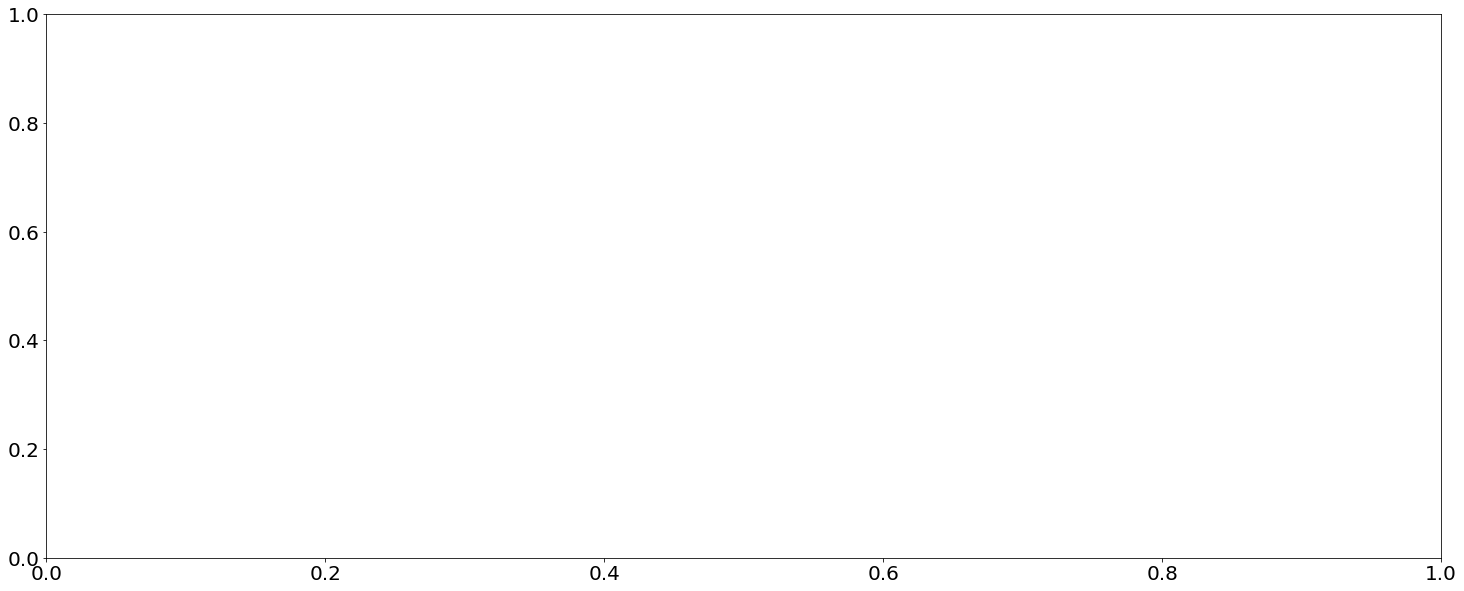

In [5]:
# explore outliers Dice
@interact
def explore_outliers(df_selected = ["df_dice", "df_hd", "df_vol"], min_=(0,1,0.1), max_=(0,1,0.1)):
    print(df_selected)
    
    df = globals().get(df_selected).copy()
    orders = list(df.variable.unique())
    print(df.describe())
    df = df[df['value'] >= df['value'].max() * float(min_)]
    df = df[df['value'] <= df['value'].max() * float(max_)]
    #orders = ["Dice LV", "Dice MYO", "Dice RV"]
    
    plt.rcParams.update({'font.size': 20})
    fig, (ax1) = plt.subplots(1, 1, figsize=(25,10), sharey=False)
    ax1 = sns.stripplot(x= 'variable',y = 'value', data=df,order=orders, ax=ax1)
    medians = df.groupby(['variable'])['value'].mean().round(2)
    sd = df.groupby(['variable'])['value'].std().round(2)
    nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]
    return df.Name
    

In [22]:
# explore outliers Dice

from ipywidgets import IntSlider

@interact
def explore_outliers(df_selected = ["df_dice", "df_hd", "df_vol"], 
                     low = IntSlider(min=0,max=3,step=1,value=0), 
                     high =IntSlider(min=0,max=3,step=1,value=3), 
                     examples=IntSlider(min=0,max=50,step=1,value=10), 
                     smallest=True):
    """
    Select a dataframe, define the label of interests and show the n best/worst examples
    params:
    df_selected: select "DICE", "vol difference" or "abolute vol" dataframe
    low: Interpret the labels as int list 0 - 3, define a range of labels with low and high, order: LV,MYO,RV
    high: upper labels limit
    examples: Define the number of lowest performer for this df and labels
    smallest: You can pick the smallest or highest dice scores with smallest=False/True
    """
    
    print(df_selected)
    
    # create a copy of the selected dataframe
    df = globals().get(df_selected).copy()
    # create a list of labels
    orders = sorted(list(df.variable.unique()))[low:high]
    # filter rows by selected labels
    df = df[df['variable'].isin(orders)]
    
    print(df.describe())
    if smallest:
        df = df.nsmallest(examples, columns=['value'])
    else:
         df = df.nlargest(examples, columns=['value'])
    #orders = ["Dice LV", "Dice MYO", "Dice RV"]
    
    plt.rcParams.update({'font.size': 20})
    fig, (ax1) = plt.subplots(1, 1, figsize=(25,10), sharey=False)
    ax1 = sns.stripplot(x= 'variable',y = 'value', data=df,order=orders, ax=ax1)
    medians = df.groupby(['variable'])['value'].mean().round(2)
    sd = df.groupby(['variable'])['value'].std().round(2)
    nobs = ['{}+/-{}'.format(m,s) for m,s in zip(medians, sd)]
    return df.Name

interactive(children=(Dropdown(description='df_selected', options=('df_dice', 'df_hd', 'df_vol'), value='df_di…